# BitPredict

Let's write some Tensorflow code to predict the price of Bitcoin based on the historical price of Bitcoin.

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we donloaded the data from here:
https://www.coindesk.com/price/bitcoin

In [3]:
# Download Bitcoin historical data from GitHub 
!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


Saved under BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


## Importing time series with pandas

In [7]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the data
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date']) # parse the date column (tell pandas column 1 is a datetime)

In [8]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [9]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [11]:
# How many samples do we have
len(df)

2787

We've collected the historical price of Bitcoin for the pas ~8 years but there's only 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (thousands to tens of thoushand to millions)

A smaller number of samples is something you'll often run into with time series data problems.

> **Note**: The **seasonality** of a time series dataset is referred as the number of samples oer year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [12]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


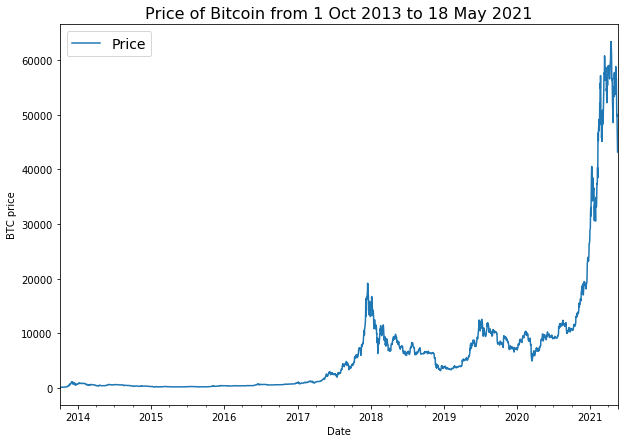

In [13]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14);

In [15]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',') # read in the target CSV
    next(csv_reader) # skip first line (this gets rid of the column titles)

    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1],'%Y-%m-%d'))  # get the dates as dates (not strings), strptime = string parse time
        btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

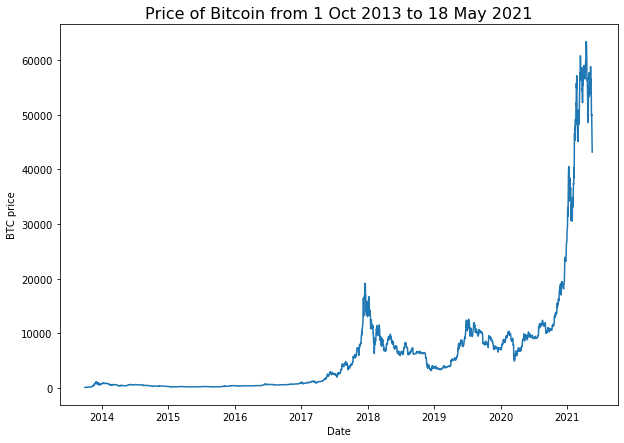

In [16]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date');

## Format Data Part 1: Creatining train and test sets for time series data

### Create train & test sets for time series (the wrong way)

In [17]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [18]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

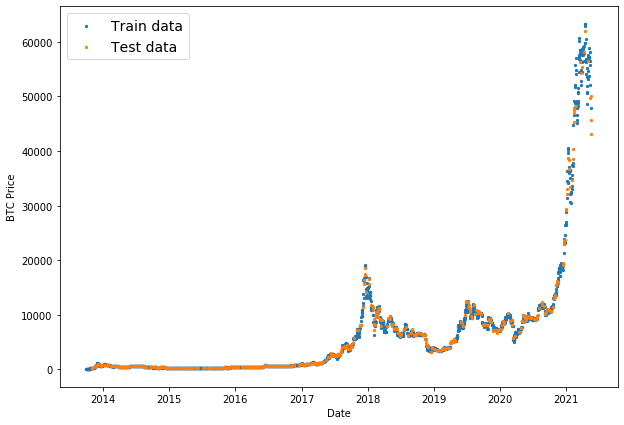

In [19]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Create train & test sets for time series (the right way)

In [20]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can chagne these value

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

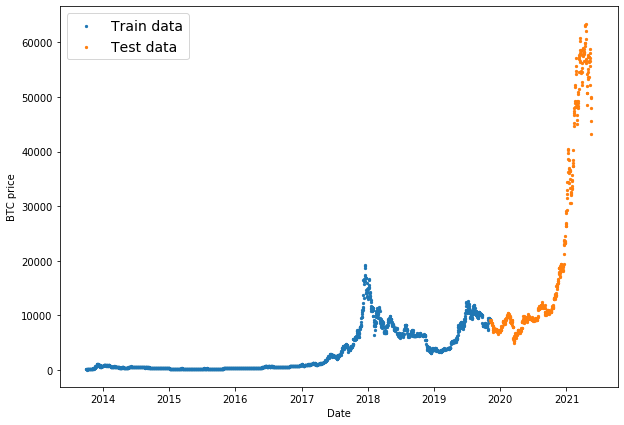

In [21]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC price')
plt.legend(fontsize=14)
plt.show()

## Create a plotting function

Typing plotting code is tedious, lets functionize it

In [22]:
# Create a function to plot time series data
def plot_time_series(timesteps, values ,format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
    
    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values, default None
    """

    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('BTC price')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

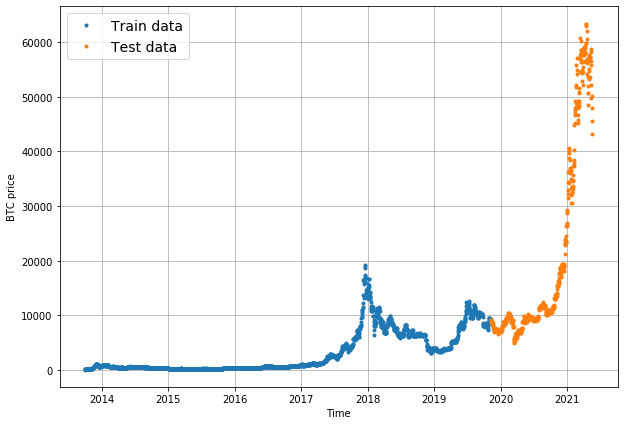

In [23]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modellling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best


Modelling experiments we're running:

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon


| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0: Naïve forecast (baseline)


The formula looks like this

$$\hat{y}_{t} = y_{t-1}$$

In English
> The prediciton at timestep t ($\hat{y}$) is equal to the is equal to the value of timestep t-1 ($y_{t-1}$)

In [24]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [25]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [26]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

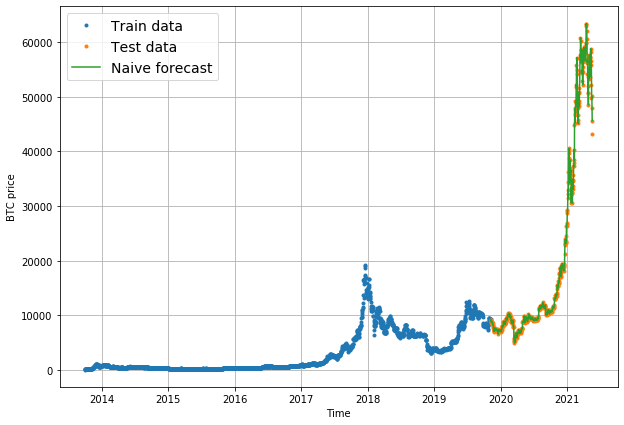

In [27]:
# Plot naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast')

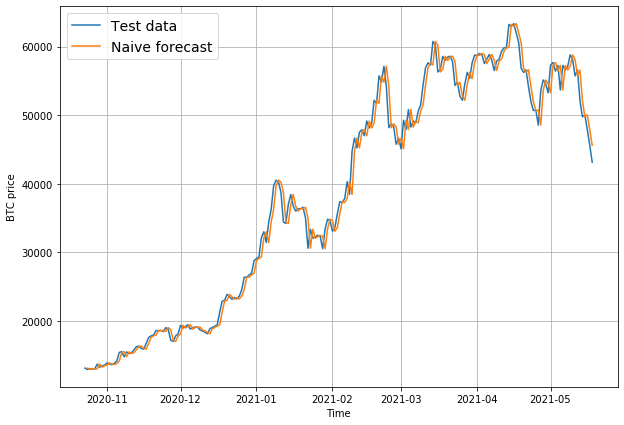

In [28]:
# Plot naive forecast
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=350, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format='-', label='Naive forecast')

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting

What are we doing?

We're predicting a number, so that means we have a form of regression problem.

Because we're working on a regressing problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean square error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean abosolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is **how do our model's forecast (y_pred) compare against the actual values (y_true) or ground truth values?**

> Resource: We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), I'd recommend reading through here for a more in-depth overview of what we're going to practice.


In [29]:
import tensorflow as tf

In [31]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """

    mae = tf.reduce_mean(tf.abs(y_true-y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # (our seasonlity is one day hence the shift of 1)
    return mae / mae_naive_no_season

In [32]:
# For naive forecast the mase if 1
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

# mase < 1 means that that the forecast is better than naive forecast
# mase > 1 means that that the forecast is worse than naive forecast

0.9995699939182624

In [33]:
y_test[0].dtype

dtype('float64')

In [34]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        'mae': mae.numpy(),
        'mse': mse.numpy(),
        'rmse': rmse.numpy(),
        'mape': mape.numpy(),
        'mase': mase.numpy()
    }

In [35]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

In [36]:
naive_forecast[-10:]
# mae - on average each of the forecast is off by 567.9802 from the actual value

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [37]:
tf.reduce_mean(y_test) #(567.9802 * 100)/20056.632963737226 = 2.8% ### The error is 2.8% of the avarage

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

In [38]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However, there are plenty of other styles of time series forecasting models you may want to experiment with.

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

Why do we window?

We window our time series to turn our data inot a supervised learning problem.

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [39]:
# What we want to do with our Bitcoin data
print(f"We want to use {btc_price[:7]} to predict this : {btc_price[7]}")

We want to use [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this : 123.033


In [40]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # precdict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [41]:
# create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels from windowed dataset

    E.g. if horizon=1 (default)
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [42]:
# Test out the window labelling funciton
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
test_window, test_label
print(f"Window {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label.numpy())}")

Window [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time plot_time_series

We could do this with Python for loops, however, for large time series that would be too slow
To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series (e.g the historical price of Bitcoin)
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [43]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D arrray into a 2D array of sequential labelled windows of window_size with horizon size labels
    """

    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    
    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

    # 3. Index on the target array (a time series) with 2D array of multiple windows steps
    windowed_array = x[window_indexes]
    
    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels


In [44]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [45]:
# View th first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label [125.96116]


In [46]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label [43144.47129086]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).


## Turning windows into training and test sets 

In [47]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [48]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [49]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels  = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels) 

(2224, 556, 2224, 556)

In [50]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [51]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modellling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we cssn compare apples to apples

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're are training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling callback using the using [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)



In [52]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                              monitor='val_loss',
                                              verbose=0,  # only output a limited amount of text
                                              save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation. 

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [53]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproucable results as possible
tf.random.set_seed(42)

# 1. Construct_model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear'), # linear activation is the same as having no activation
], name='model_1_dense') # name our model so we can save it

# 2. Compile
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
18/18 [==============================] - 3s 127ms/step - loss: 780.3469 - mae: 780.3469 - mse: 2312739.0000 - val_loss: 2279.5830 - val_mae: 2279.5830 - val_mse: 12772096.0000
Epoch 2/100
18/18 [==============================] - 1s 82ms/step - loss: 247.6765 - mae: 247.6765 - mse: 285480.9688 - val_loss: 1005.9865 - val_mae: 1005.9865 - val_mse: 3441759.5000
Epoch 3/100
18/18 [==============================] - 1s 78ms/step - loss: 188.4107 - mae: 188.4107 - mse: 171890.0312 - val_loss: 923.2859 - val_mae: 923.2859 - val_mse: 2868195.0000
Epoch 4/100
18/18 [==============================] - 1s 71ms/step - loss: 169.4334 - mae: 169.4334 - mse: 151699.4375 - val_loss: 900.5931 - val_mae: 900.5931 - val_mse: 2683713.5000
Epoch 5/100
18/18 [==============================] - 1s 77ms/step - loss: 165.0899 - mae: 165.0899 - mse: 145490.8906 - val_loss: 895.2405 - val_mae: 895.2405 - val_mse: 2564605.7500
Epoch 6/100
18/18 [==============================] - 1s 82ms/step - loss: 158.

18/18 [==============================] - 2s 95ms/step - loss: 114.0328 - mae: 114.0328 - mse: 77953.4609 - val_loss: 610.3880 - val_mae: 610.3880 - val_mse: 1316937.2500
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 113.4892 - mae: 113.4892 - mse: 78513.1016 - val_loss: 617.2402 - val_mae: 617.2402 - val_mse: 1304227.6250
Epoch 30/100
18/18 [==============================] - 1s 70ms/step - loss: 116.4094 - mae: 116.4094 - mse: 78943.1562 - val_loss: 603.6489 - val_mae: 603.6489 - val_mse: 1283177.8750
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3454 - mae: 112.3454 - mse: 74879.3281 - val_loss: 623.4432 - val_mae: 623.4432 - val_mse: 1311037.0000
Epoch 32/100
18/18 [==============================] - 2s 90ms/step - loss: 113.2056 - mae: 113.2056 - mse: 77898.5078 - val_loss: 600.0259 - val_mae: 600.0259 - val_mse: 1271945.3750
Epoch 33/100
18/18 [==============================] - 0s 8ms/step - loss: 112.9529 - mae: 112.9529 -

18/18 [==============================] - 0s 9ms/step - loss: 111.8451 - mae: 111.8451 - mse: 73612.9453 - val_loss: 654.6138 - val_mae: 654.6138 - val_mse: 1348993.1250
Epoch 64/100
18/18 [==============================] - 0s 9ms/step - loss: 110.3121 - mae: 110.3121 - mse: 72546.6641 - val_loss: 610.7808 - val_mae: 610.7808 - val_mse: 1251885.0000
Epoch 65/100
18/18 [==============================] - 1s 76ms/step - loss: 109.7098 - mae: 109.7098 - mse: 72575.0938 - val_loss: 573.9961 - val_mae: 573.9961 - val_mse: 1190387.8750
Epoch 66/100
18/18 [==============================] - 2s 103ms/step - loss: 106.8139 - mae: 106.8139 - mse: 70554.2734 - val_loss: 572.9990 - val_mae: 572.9990 - val_mse: 1187547.6250
Epoch 67/100
18/18 [==============================] - 0s 8ms/step - loss: 106.1394 - mae: 106.1394 - mse: 70026.4297 - val_loss: 602.1526 - val_mae: 602.1526 - val_mse: 1255793.7500
Epoch 68/100
18/18 [==============================] - 0s 8ms/step - loss: 112.9245 - mae: 112.9245 -

In [55]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

In [56]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 662.5316 - mae: 662.5316 - mse: 1358190.2500


[662.5316162109375, 662.5316162109375, 1358190.25]

In [57]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense/')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.5498 - mae: 568.5498 - mse: 1172587.5000


[568.5498046875, 568.5498046875, 1172587.5]

## Making forecasts with the model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psudeo forecasts because actual forecasts are into the future), let's write a funciton to:

1. Takes in a trained model (just like model_1)
2. Takes in some input data (just like the data the model was trained on)
2. Passes the input data to the model's predict() method
3. Returns the predictions

In [58]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    Parameters
    ----------
    model: trained model 
    input_data: windowed input data (same kind of data model was trained on)

    Returns model predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predicitons

In [59]:
# Make precicitons using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8874.493, 8789.944, 9040.987, 8804.829, 8741.212, 8749.836,
        8705.867, 8513.171, 8478.415, 8536.302], dtype=float32)>)

In [60]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [61]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492294,
 'mase': 0.99878466}

In [62]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

In [63]:
len(test_windows)

556

In [64]:
test_labels.shape

(556, 1)

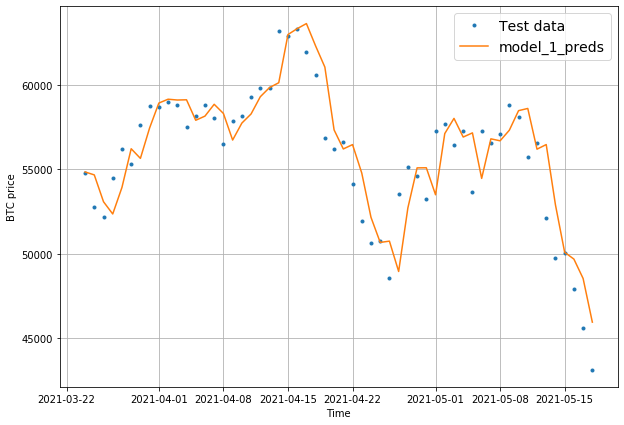

In [65]:
# Let's plot our model 1 predicitons
offset=500
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='Test data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format='-', label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [66]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [67]:
# Make window data with approriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [68]:
# Make and train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [69]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# comnpile
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [70]:
# Evaluate model 3 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 658.0291


658.029052734375

In [71]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.8481


608.8480834960938

In [72]:
# Get forecasst predictions
model_2_preds = make_preds(model_2, input_data=test_windows)

In [73]:
# Evaluate results for model 2 predicitons
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 608.848,
 'mse': 1284314.4,
 'rmse': 1133.276,
 'mape': 2.7680664,
 'mase': 1.0642723}

In [74]:
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492294,
 'mase': 0.99878466}

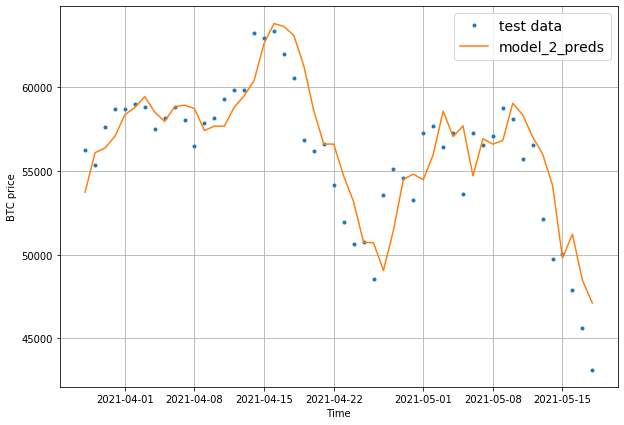

In [75]:
offset = 500
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='test data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format='-', label='model_2_preds')

Below is an explaination of how the data is divided for less confusion

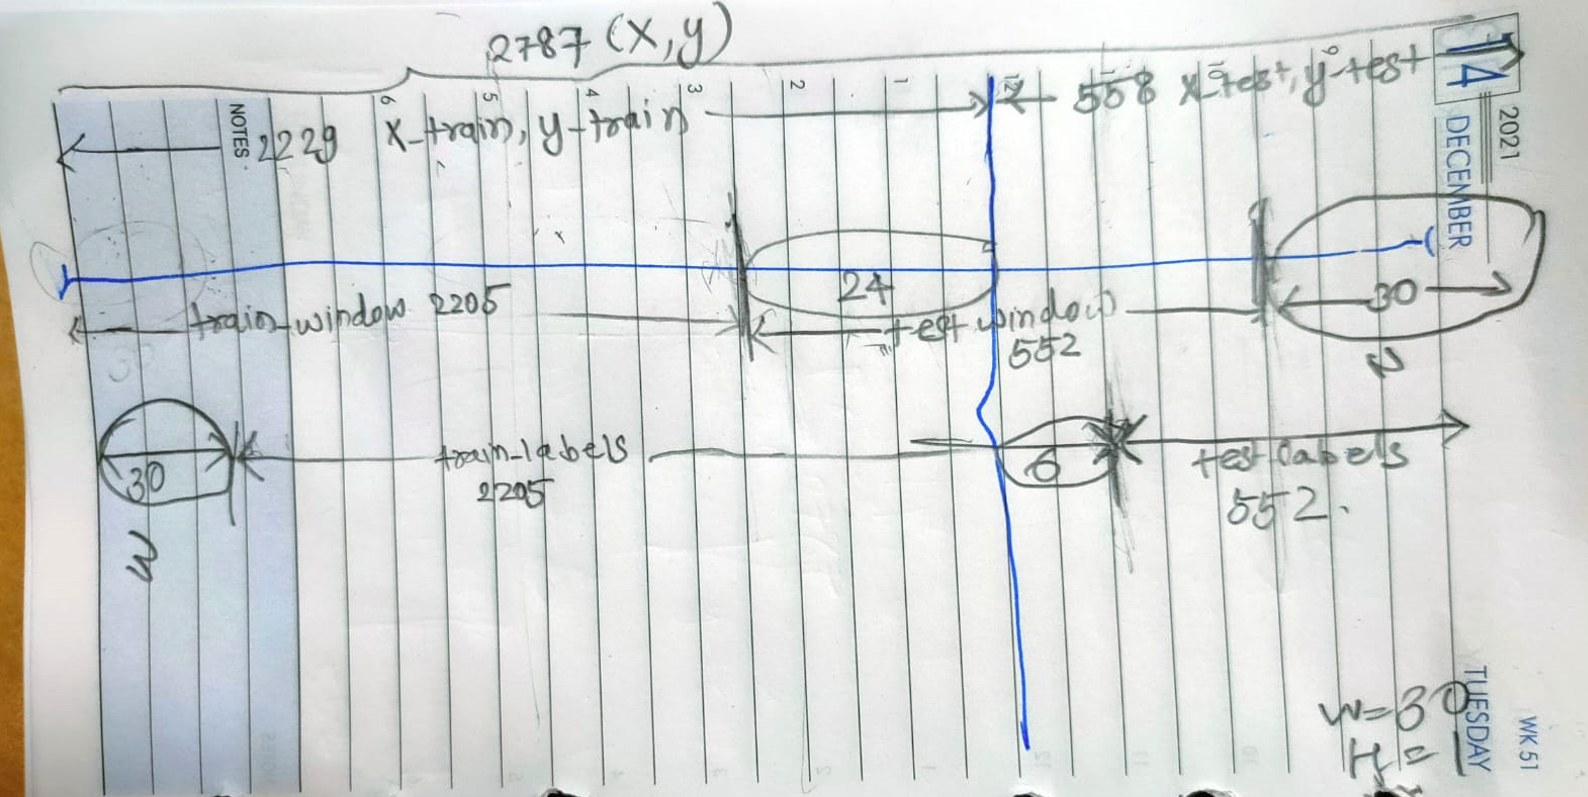

## Model 3: Dense (window=30, horizon=7)

In [76]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [77]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [78]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sized)
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: mod

In [79]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1317.8018


1317.8017578125

In [80]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1228.5236


1228.5235595703125

In [81]:
# Make predicitons with model_3
model_3_preds = make_preds(model_3, input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9301.03 , 9255.057, 9386.084, 9463.899, 9428.424, 9450.685,
        9256.156],
       [8981.781, 8991.779, 9133.913, 9049.854, 9020.026, 9039.194,
        9031.239],
       [8911.586, 8944.726, 9021.002, 8950.288, 8948.543, 8886.974,
        8928.808],
       [9115.924, 8980.253, 8986.703, 9148.485, 9010.879, 9093.613,
        8975.999],
       [9021.95 , 8929.939, 8846.618, 9016.343, 9156.252, 9137.509,
        8853.586]], dtype=float32)>

In [82]:
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8903.552, 8932.771, 8792.955, 8590.41 , 8454.577], dtype=float32)>

In [83]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([556]))

In [84]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': array([  569.8329  ,   309.68735 ,   285.87402 ,   417.95633 ,
          440.2518  ,   532.69415 ,   539.9028  ,   458.60135 ,
          513.77826 ,   634.0573  ,   804.88763 ,   734.7355  ,
          678.25916 ,   792.92694 ,   567.4803  ,   276.1914  ,
          235.29234 ,   244.68924 ,   286.03802 ,   284.581   ,
          134.6077  ,   155.0277  ,   221.26717 ,   278.0025  ,
          175.6605  ,   155.22754 ,    91.86879 ,    98.08378 ,
          122.0097  ,   162.57045 ,   289.1723  ,   390.6123  ,
          290.6882  ,   282.27972 ,   280.6268  ,   257.2563  ,
          327.1397  ,   249.74352 ,   250.42424 ,   255.33469 ,
          410.17355 ,   135.01945 ,   104.09745 ,    84.98556 ,
          113.40995 ,    92.47168 ,    69.050224,    83.27602 ,
           85.60456 ,    91.71575 ,   127.40172 ,   137.71834 ,
          193.87074 ,   160.65457 ,   253.00285 ,   390.39877 ,
          549.7675  ,   535.5915  ,   529.62646 ,   518.6678  ,
          424.58057 ,   249.47092

## Make our evaluation function work for larger horizons

In [85]:
model_3_results['mae'].shape, model_3_results['mae'].ndim

((551,), 1)

In [86]:
model_2_results['mae'].shape, model_2_results['mae'].ndim

((), 0)

In [87]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1228.5236


1228.5235595703125

In [88]:
tf.reduce_mean(model_3_results['mae']).numpy()

1228.5237

In [89]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
        
    return {
        'mae': mae.numpy(),
        'mse': mse.numpy(),
        'rmse': rmse.numpy(),
        'mape': mape.numpy(),
        'mase': mase.numpy()
    }

In [90]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': 1228.5237,
 'mse': 5328784.5,
 'rmse': 1413.7472,
 'mape': 5.4774456,
 'mase': 2.186089}

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!

In [91]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9301.03 , 9255.057, 9386.084, 9463.899, 9428.424, 9450.685,
        9256.156],
       [8981.781, 8991.779, 9133.913, 9049.854, 9020.026, 9039.194,
        9031.239],
       [8911.586, 8944.726, 9021.002, 8950.288, 8948.543, 8886.974,
        8928.808],
       [9115.924, 8980.253, 8986.703, 9148.485, 9010.879, 9093.613,
        8975.999],
       [9021.95 , 8929.939, 8846.618, 9016.343, 9156.252, 9137.509,
        8853.586]], dtype=float32)>

In [92]:
test_labels[:, 0]

array([ 8794.35864452,  8798.04205463,  9081.18687849,  8711.53433917,
        8760.89271814,  8749.52059102,  8656.97092235,  8500.64355816,
        8469.2608989 ,  8537.33965197,  8205.80636599,  8118.4885358 ,
        8074.84317361,  7612.7405735 ,  7262.11053495,  7303.40575852,
        7041.73293642,  7211.86180875,  7141.06944869,  7523.4806726 ,
        7390.20746923,  7729.26593894,  7542.23560864,  7381.96300782,
        7333.43293049,  7315.36776456,  7213.73376172,  7398.78704961,
        7511.88058312,  7532.12351309,  7550.23919987,  7333.09604316,
        7239.76257544,  7198.06667705,  7190.27236926,  7238.87432299,
        7087.02498535,  7112.73147612,  6883.49639377,  6584.02884335,
        7424.01540023,  7147.56832379,  7139.93337053,  7286.33508116,
        7236.98620461,  7166.17237853,  7235.6266505 ,  7212.80939522,
        7183.70653603,  7227.29371168,  7311.56064392,  7385.46484791,
        7251.27679432,  7179.95781929,  7174.74401195,  6955.48757967,
      

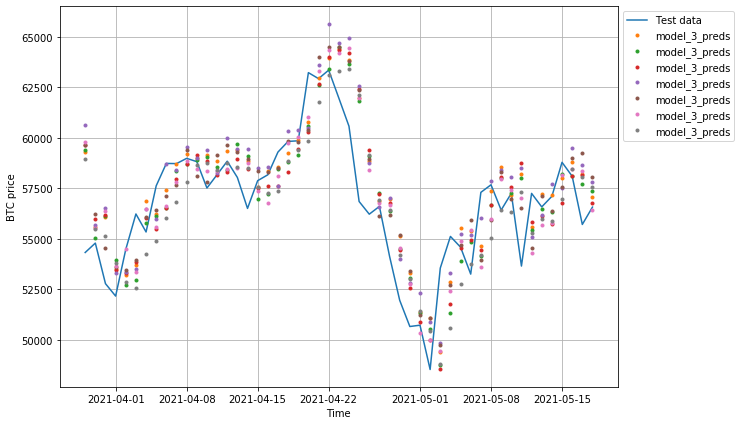

In [93]:
offset = 500
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format='-', label='Test data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label='model_3_preds')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)); # for bbbox to anchor we use (0,0) as the bottom left instead of the top left

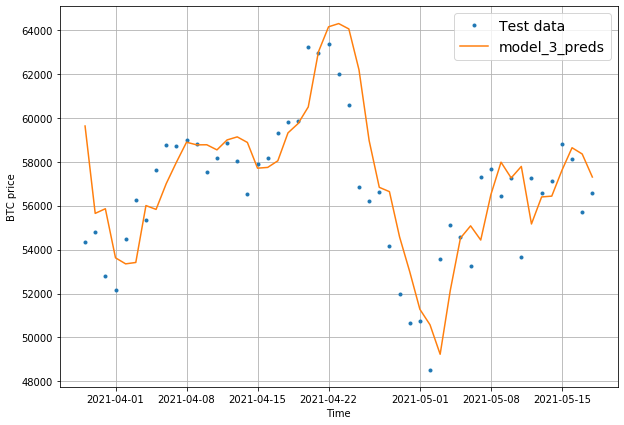

In [94]:
offset = 500
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label='Test data')

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format='-',
                 label='model_3_preds')

## Which of our models is performing the best so far?
So far, we've trained 3 models which use the same architecture but use different data inputs.

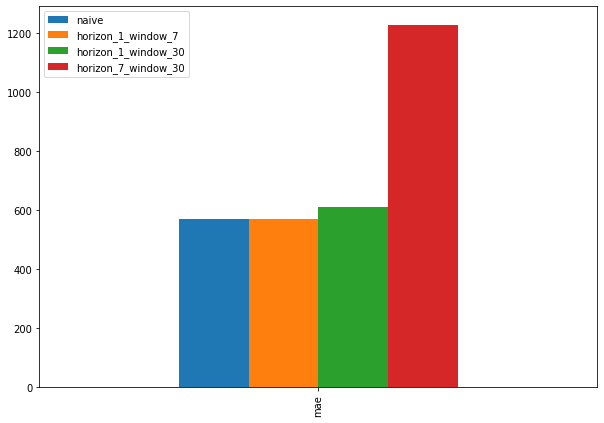

In [95]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=['mae']).plot(figsize=(10, 7), kind='bar');

In [96]:
# calculate autocorrelation
import statsmodels.api as sm
sm.tsa.acf(prices, nlags=1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([1.        , 0.99670773])

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik


## Model 4: Conv1D

In [97]:
HORIZON = 1 # predict next day of Bitcoing prices
WINDOW_SIZE = 7 # use previous week worth of data

In [98]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [99]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need input shape of (batch_size, timesteps, input_dim) ...

However our data isn't in that shape yet...

Data windowed!

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [100]:
# Check data input shape
train_windows[0].shape # return (WINDOW_SIZe, )

(7,)

In [101]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [102]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [103]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE, )
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = 
print(f"Original values with epanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with epanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [104]:
x.numpy()

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [105]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Flatten(),
    layers.Dense(HORIZON),
], name='model_4_conv1D')

# Compile model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets
INFO:tensorflow:Assets wr

In [106]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [107]:
# Evaluate model ...
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 624.1892


624.189208984375

In [108]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 569.0327


569.0326538085938

In [109]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8847.292, 8757.502, 8997.47 , 8762.801, 8707.723, 8713.594,
       8664.936, 8496.83 , 8439.471, 8499.395], dtype=float32)>

In [110]:
# Evaluate predicitons
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)
model_4_results

{'mae': 569.0327,
 'mse': 1169841.5,
 'rmse': 1081.5922,
 'mape': 2.5515258,
 'mase': 0.9996329}

In [111]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously

In [112]:
train_windows[:5]

array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ],
       [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
        123.033  ],
       [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
        124.049  ],
       [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
        125.96116],
       [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
        125.27966]])

In [113]:
tf.random.set_seed(42)

# Let's build an LSTM model with functional api
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation='relu')(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_LSTM')

# compile
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
70/70 [==============================] - ETA: 0s - loss: 923.8523 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 7s 67ms/step - loss: 923.8523 - val_loss: 999.7691
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 174.3586 - val_loss: 1059.5997
Epoch 3/100
63/70 [==========================>...] - ETA: 0s - loss: 170.6281INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 61ms/step - loss: 169.0972 - val_loss: 915.7006
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 163.8711 - val_loss: 985.2815
Epoch 5/100
61/70 [=========================>....] - ETA: 0s - loss: 168.2040INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 66ms/step - loss: 165.7203 - val_loss: 893.5099
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 157.6356 - val_loss: 925.5924
Epoch 7/100
67/70 [===========================>..] - ETA: 0s - loss: 156.5667INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 63ms/step - loss: 155.1540 - val_loss: 865.0233
Epoch 8/100
62/70 [=========================>....] - ETA: 0s - loss: 147.8825INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 62ms/step - loss: 149.9786 - val_loss: 802.7791
Epoch 9/100
70/70 [==============================] - ETA: 0s - loss: 144.7668INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 67ms/step - loss: 144.7668 - val_loss: 796.8940
Epoch 10/100
70/70 [==============================] - 0s 6ms/step - loss: 145.6867 - val_loss: 846.0704
Epoch 11/100
69/70 [============================>.] - ETA: 0s - loss: 138.6238INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 69ms/step - loss: 138.1037 - val_loss: 748.6368
Epoch 12/100
68/70 [============================>.] - ETA: 0s - loss: 132.8451INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 65ms/step - loss: 133.8784 - val_loss: 730.4849
Epoch 13/100
70/70 [==============================] - 0s 7ms/step - loss: 132.8123 - val_loss: 850.4282
Epoch 14/100
70/70 [==============================] - 0s 7ms/step - loss: 131.5384 - val_loss: 798.8928
Epoch 15/100
68/70 [============================>.] - ETA: 0s - loss: 128.6319INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 62ms/step - loss: 128.7169 - val_loss: 695.1087
Epoch 16/100
61/70 [=========================>....] - ETA: 0s - loss: 124.6956INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 70ms/step - loss: 125.2011 - val_loss: 675.9756
Epoch 17/100
70/70 [==============================] - 1s 7ms/step - loss: 123.6086 - val_loss: 702.0203
Epoch 18/100
68/70 [============================>.] - ETA: 0s - loss: 133.2344INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 67ms/step - loss: 132.2438 - val_loss: 661.0212
Epoch 19/100
70/70 [==============================] - 0s 7ms/step - loss: 124.6267 - val_loss: 678.2249
Epoch 20/100
70/70 [==============================] - 0s 7ms/step - loss: 120.9228 - val_loss: 684.8021
Epoch 21/100
70/70 [==============================] - 1s 8ms/step - loss: 120.7684 - val_loss: 704.4414
Epoch 22/100
70/70 [==============================] - 1s 7ms/step - loss: 119.1586 - val_loss: 675.6731
Epoch 23/100
70/70 [==============================] - 0s 6ms/step - loss: 121.8799 - val_loss: 735.8718
Epoch 24/100
64/70 [==========================>...] - ETA: 0s - loss: 120.5367INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 62ms/step - loss: 119.3319 - val_loss: 633.9037
Epoch 25/100
64/70 [==========================>...] - ETA: 0s - loss: 121.6317INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 74ms/step - loss: 118.6423 - val_loss: 628.7442
Epoch 26/100
70/70 [==============================] - 0s 6ms/step - loss: 125.5400 - val_loss: 685.3659
Epoch 27/100
70/70 [==============================] - 0s 6ms/step - loss: 122.3811 - val_loss: 680.9153
Epoch 28/100
59/70 [========================>.....] - ETA: 0s - loss: 113.4797INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 66ms/step - loss: 115.8621 - val_loss: 616.0474
Epoch 29/100
70/70 [==============================] - 1s 9ms/step - loss: 119.4341 - val_loss: 618.9126
Epoch 30/100
70/70 [==============================] - 0s 7ms/step - loss: 115.2532 - val_loss: 627.5763
Epoch 31/100
70/70 [==============================] - 1s 8ms/step - loss: 117.9696 - val_loss: 688.6986
Epoch 32/100
70/70 [==============================] - 1s 9ms/step - loss: 116.9927 - val_loss: 631.9073
Epoch 33/100
70/70 [==============================] - 0s 7ms/step - loss: 115.3283 - val_loss: 637.9200
Epoch 34/100
70/70 [==============================] - 0s 7ms/step - loss: 121.1977 - val_loss: 624.1882
Epoch 35/100
60/70 [========================>.....] - ETA: 0s - loss: 117.3599INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 66ms/step - loss: 114.8490 - val_loss: 609.4012
Epoch 36/100
67/70 [===========================>..] - ETA: 0s - loss: 121.0447INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 7s 98ms/step - loss: 121.4234 - val_loss: 608.9478
Epoch 37/100
64/70 [==========================>...] - ETA: 0s - loss: 112.4411INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 7s 95ms/step - loss: 112.8643 - val_loss: 597.1259
Epoch 38/100
70/70 [==============================] - 1s 9ms/step - loss: 120.1114 - val_loss: 736.4162
Epoch 39/100
70/70 [==============================] - 0s 6ms/step - loss: 118.4854 - val_loss: 730.7971
Epoch 40/100
70/70 [==============================] - 1s 11ms/step - loss: 119.6286 - val_loss: 599.8910
Epoch 41/100
70/70 [==============================] - 1s 7ms/step - loss: 111.9520 - val_loss: 645.2111
Epoch 42/100
70/70 [==============================] - 1s 11ms/step - loss: 112.6215 - val_loss: 600.8961
Epoch 43/100
70/70 [==============================] - 1s 10ms/step - loss: 116.4833 - val_loss: 653.7863
Epoch 44/100
70/70 [==============================] - 1s 9ms/step - loss: 113.1121 - val_loss: 635.4329
Epoch 45/100
66/70 [===========================>..] - ETA: 0s - loss: 111.0862INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 75ms/step - loss: 112.1209 - val_loss: 594.4921
Epoch 46/100
70/70 [==============================] - 0s 6ms/step - loss: 121.8768 - val_loss: 628.7536
Epoch 47/100
70/70 [==============================] - 0s 6ms/step - loss: 111.6641 - val_loss: 707.7673
Epoch 48/100
67/70 [===========================>..] - ETA: 0s - loss: 115.7431INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 80ms/step - loss: 115.5611 - val_loss: 588.2557
Epoch 49/100
60/70 [========================>.....] - ETA: 0s - loss: 111.8003INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 73ms/step - loss: 111.4636 - val_loss: 586.5911
Epoch 50/100
70/70 [==============================] - 0s 5ms/step - loss: 111.5096 - val_loss: 602.1368
Epoch 51/100
70/70 [==============================] - 0s 5ms/step - loss: 113.7116 - val_loss: 627.9661
Epoch 52/100
70/70 [==============================] - 0s 6ms/step - loss: 116.8212 - val_loss: 600.7237
Epoch 53/100
70/70 [==============================] - 0s 6ms/step - loss: 111.5045 - val_loss: 598.9944
Epoch 54/100
70/70 [==============================] - 0s 6ms/step - loss: 113.0562 - val_loss: 632.6453
Epoch 55/100
70/70 [==============================] - 0s 6ms/step - loss: 113.4896 - val_loss: 638.2128
Epoch 56/100
70/70 [==============================] - 0s 6ms/step - loss: 112.4208 - val_loss: 598.4015
Epoch 57/100
60/70 [========================>.....] - ETA: 0s - loss: 113.3830INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 66ms/step - loss: 112.1551 - val_loss: 582.5767
Epoch 58/100
70/70 [==============================] - 0s 7ms/step - loss: 111.9165 - val_loss: 596.3997
Epoch 59/100
70/70 [==============================] - 0s 6ms/step - loss: 111.4105 - val_loss: 593.3812
Epoch 60/100
70/70 [==============================] - 0s 6ms/step - loss: 109.4233 - val_loss: 600.8105
Epoch 61/100
65/70 [==========================>...] - ETA: 0s - loss: 113.6835INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 69ms/step - loss: 111.4582 - val_loss: 578.3188
Epoch 62/100
70/70 [==============================] - 0s 7ms/step - loss: 109.2855 - val_loss: 587.6647
Epoch 63/100
70/70 [==============================] - 0s 6ms/step - loss: 109.8768 - val_loss: 605.4911
Epoch 64/100
70/70 [==============================] - 0s 7ms/step - loss: 119.9885 - val_loss: 638.4092
Epoch 65/100
69/70 [============================>.] - ETA: 0s - loss: 113.1301INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 68ms/step - loss: 112.9174 - val_loss: 576.9272
Epoch 66/100
70/70 [==============================] - 0s 7ms/step - loss: 109.1694 - val_loss: 594.9652
Epoch 67/100
70/70 [==============================] - 0s 6ms/step - loss: 109.6172 - val_loss: 580.5194
Epoch 68/100
70/70 [==============================] - 0s 6ms/step - loss: 108.1880 - val_loss: 577.1382
Epoch 69/100
70/70 [==============================] - 0s 6ms/step - loss: 114.0097 - val_loss: 748.2090
Epoch 70/100
70/70 [==============================] - 0s 7ms/step - loss: 110.4246 - val_loss: 632.7281
Epoch 71/100
70/70 [==============================] - 1s 8ms/step - loss: 121.1179 - val_loss: 597.2792
Epoch 72/100
70/70 [==============================] - 0s 7ms/step - loss: 110.8437 - val_loss: 624.5787
Epoch 73/100
70/70 [==============================] - 1s 8ms/step - loss: 108.8602 - val_loss: 582.9574
Epoch 74/100
68/70 [============================>.] - ETA: 0s - loss: 113.96

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 69ms/step - loss: 114.0375 - val_loss: 575.2063
Epoch 75/100
70/70 [==============================] - 1s 8ms/step - loss: 110.0358 - val_loss: 625.2244
Epoch 76/100
62/70 [=========================>....] - ETA: 0s - loss: 112.5354INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 67ms/step - loss: 112.2455 - val_loss: 573.6019
Epoch 77/100
70/70 [==============================] - 0s 6ms/step - loss: 110.6669 - val_loss: 575.9926
Epoch 78/100
70/70 [==============================] - 0s 5ms/step - loss: 111.2233 - val_loss: 574.5059
Epoch 79/100
70/70 [==============================] - 0s 7ms/step - loss: 110.1821 - val_loss: 723.6767
Epoch 80/100
70/70 [==============================] - 0s 6ms/step - loss: 114.9784 - val_loss: 594.9142
Epoch 81/100
70/70 [==============================] - 0s 5ms/step - loss: 108.1764 - val_loss: 616.5611
Epoch 82/100
70/70 [==============================] - 0s 6ms/step - loss: 119.8773 - val_loss: 766.3946
Epoch 83/100
70/70 [==============================] - 1s 8ms/step - loss: 113.0083 - val_loss: 582.9174
Epoch 84/100
70/70 [==============================] - 0s 7ms/step - loss: 108.9823 - val_loss: 578.7323
Epoch 85/100
70/70 [==============================] - 0s 6ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 61ms/step - loss: 110.3275 - val_loss: 572.0526
Epoch 89/100
70/70 [==============================] - 0s 6ms/step - loss: 112.6318 - val_loss: 682.7905
Epoch 90/100
70/70 [==============================] - 0s 7ms/step - loss: 109.8617 - val_loss: 617.6616
Epoch 91/100
65/70 [==========================>...] - ETA: 0s - loss: 111.3671INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 68ms/step - loss: 110.5174 - val_loss: 570.7661
Epoch 92/100
70/70 [==============================] - 0s 7ms/step - loss: 108.2848 - val_loss: 590.0091
Epoch 93/100
67/70 [===========================>..] - ETA: 0s - loss: 110.0423INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 5s 70ms/step - loss: 109.5453 - val_loss: 570.5269
Epoch 94/100
70/70 [==============================] - 1s 7ms/step - loss: 113.3878 - val_loss: 719.5934
Epoch 95/100
70/70 [==============================] - 0s 6ms/step - loss: 109.5538 - val_loss: 576.3531
Epoch 96/100
70/70 [==============================] - 0s 7ms/step - loss: 113.0247 - val_loss: 608.1163
Epoch 97/100
70/70 [==============================] - 0s 6ms/step - loss: 110.0842 - val_loss: 572.4985
Epoch 98/100
65/70 [==========================>...] - ETA: 0s - loss: 112.0229INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 64ms/step - loss: 110.8421 - val_loss: 569.5883
Epoch 99/100
70/70 [==============================] - 0s 6ms/step - loss: 110.3717 - val_loss: 597.3601
Epoch 100/100
63/70 [==========================>...] - ETA: 0s - loss: 112.9723INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


70/70 [==============================] - 4s 65ms/step - loss: 109.3761 - val_loss: 568.9805


In [114]:
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [115]:
# Load in best verseion of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.9805


568.9805297851562

In [116]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8890.783, 8788.479, 9049.464, 8816.014, 8737.119, 8762.857,
       8713.359, 8523.354, 8486.732, 8542.195], dtype=float32)>

In [117]:
# Evaluate model 5 predicitons
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 568.98065,
 'mse': 1177185.4,
 'rmse': 1084.9817,
 'mape': 2.53525,
 'mase': 0.9995414}

In [118]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

Hmmm... it seems even with an LSTM-powered RNN we weren't able to beat our naïve models results.

Perhaps adding another variable will help?

> 🔑 **Note:** I'm putting this here again as a reminder that because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series

Before we add a feature to our time series, what is a feature we can use?

One feature is whether or not Danie Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feture to use?

How about the bitcoin halving events https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [119]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [120]:
# Let's add the bitcoin halving events to our dataset

# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 - this reward isn't in our dataset (it starts from 01 October 2013)
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates (datetime from the above timestamps)
# block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-18')

In [121]:
# Create date ranges of where specific block_rewaard values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [122]:
# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Set values of block_reward column
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


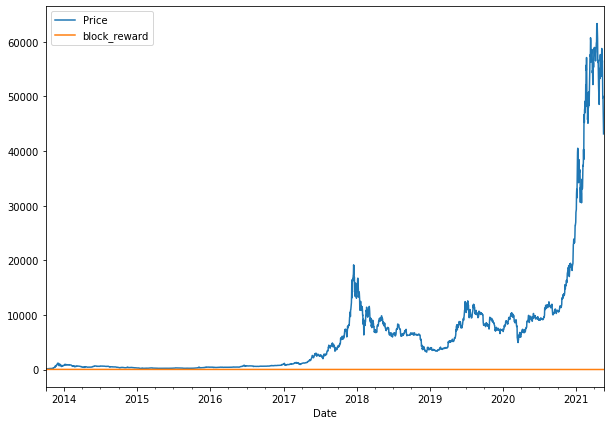

In [123]:
bitcoin_prices_block.plot(figsize=(10,7));
# We need to scale the y axis to the same range

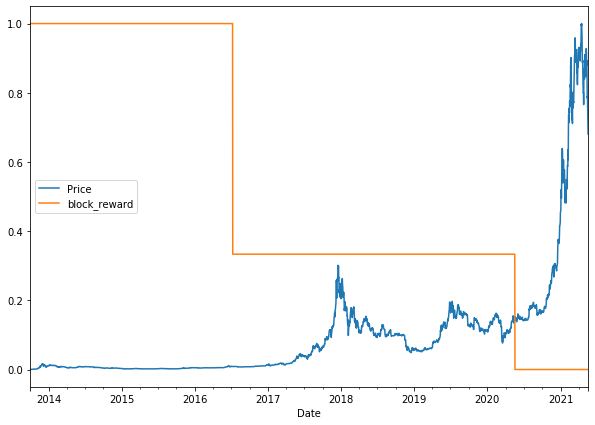

In [124]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price', 'block_reward']]),
                                                  columns=bitcoin_prices_block.columns,
                                                  index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our univariate time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the pandas.DataFrame.shift() method to create a windowed multivariate time series.

The [shift()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) method offsets an index by a specified number of periods.


In [125]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [126]:
# Make a copy of the Bitcoin historical data with block reward feture
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift balues for each step in WINDOW_SIZe
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed['Price'].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [127]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done i s create a way to window our dataset directly from a pandas dataframe

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [128]:
# create X (windows) and y (horizon) features
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [129]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [130]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [131]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

# Compile
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())
# Fit
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


In [132]:
# Evaluate the multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 660.5464


660.54638671875

In [133]:
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 568.4492


568.44921875

In [134]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8854.9375, 8783.561 , 9061.753 , 8759.416 , 8737.171 , 8784.179 ,
       8680.541 , 8514.698 , 8481.642 , 8540.749 ], dtype=float32)>

In [135]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.4492,
 'mse': 1166159.0,
 'rmse': 1079.8884,
 'mape': 2.5497673,
 'mase': 0.9986078}

In [136]:
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492294,
 'mase': 0.99878466}

In [137]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

> 📖 **Resource:** For different ideas on how to improve a neural network model (from a model perspective), refer to the [*Improving a model*](https://dev.mrdbourke.com/tensorflow-deep-learning/02_neural_network_classification_in_tensorflow/#improving-a-model) section in notebook 02.

## Model 7: N-BEATS algorithm


We're going to be replicating the the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?
* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use Tensorflow layer subclassing (to make our own layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our problem


### Building and testing the N-BEATS block layer

Because the N-BEATS block layer does not exist in Tensorflow, we've got to create it.

To create custom layers and models in Tensorflow we can use [sub-classing](https://www.tensorflow.org/guide/keras/custom_layers_and_models) with 
[`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

In [138]:
# Create NBeatsBlock custom layer

class NBeatsBlock(tf.keras.layers.Layer):

    def __init__(self, input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
        
        
        super().__init__(**kwargs)
        
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
        
        # Output of block is a theta layer with a linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

    def call(self, inputs):

        x = inputs
        for layer in self.hidden:
            x  = layer(x)

        theta = self.theta_layer(x)

        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast


Let's test our NBeatsBlock class

To do this we'll make some dummy inputs and outputs

In [139]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [140]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+ 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [141]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {backcast}, shape = {backcast.shape}")
print("\n")
print(f"Forecast: {forecast}, shape = {forecast.shape}")

Backcast: [[ 0.19014972  0.8379835  -0.32870024  0.2515991  -0.47540277 -0.7783665
  -0.52994466]], shape = (1, 7)


Forecast: [[-0.75542134]], shape = (1, 1)


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the [tf.data guide](https://www.tensorflow.org/guide/data_performance):



In [142]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [143]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [144]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [145]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [146]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2224, 7), (2224,), (556, 7), (556,))

In [147]:
# Time to make our dataset performant using tf.data API

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features and labels by zipping together
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparamets for N-BEAST algorithnm

The N-BEATS algorithm has a fair few nuber of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)

In [148]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add)

The N-BEATS algorithm uses **double residual stacking** to help train its deeper architecture (section 3.2 of N-BEATS paper)

* For more on rediual connections see: https://en.wikipedia.org/wiki/Residual_neural_network
* And here: https://paperswithcode.com/method/resnet

In [149]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])>)

In [150]:
# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for long period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [151]:
%%time
tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediciton)
backcast, forecast = nbeats_block_layer(stack_input)

# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)
    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                           theta_size=THETA_SIZE,
                                           horizon=HORIZON,
                                           n_neurons=N_NEURONS,
                                           n_layers=N_LAYERS,
                                           name=f'NBeatsBlock_{i}')(residuals) # pass it in residuals (the backcast)

    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast],  name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")


# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name='model_7_N-BEATS')

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])


# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(mointor='val_loss', patience=100, verbose=1)])


Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00291: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Wall time: 16min 39s


In [152]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 281ms/step - loss: 588.3497 - mae: 588.3497 - mse: 1220197.1250


[588.3497314453125, 588.3497314453125, 1220197.125]

In [153]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8881.54 , 8786.068, 9027.536, 8809.025, 8789.067, 8756.307,
       8678.126, 8561.399, 8471.384, 8525.041], dtype=float32)>

In [154]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 588.34973,
 'mse': 1220197.1,
 'rmse': 1104.6254,
 'mape': 2.7504864,
 'mase': 1.0335675}

In [155]:
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492294,
 'mase': 0.99878466}

In [156]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.9995699}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

In [157]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combine many *different* models to predict a common goal.

In [158]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)

In [159]:
def get_ensemble_model(horizon=HORIZON,
                       train_data=train_dataset,
                       test_data=test_dataset,
                       num_iter=10,
                       num_epochs=1000,
                       loss_fns=['mae','mse','mape']):
    """
    Returns a list of num_iter models each trained on MAE, MSE, and MAPE loss

    For example, if num_iter=10, a list of 30 trained models will be returned:
    10 * len(["mae", "mse", "mape"]).
    """

    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss functions
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing {loss_function} for {num_epochs} epochs, model number {i}")

            # Constructing a simple model(similar to model_1)
            model = tf.keras.Sequential([
                # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
                # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
                layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                layers.Dense(HORIZON)
            ])

            # Compile simple model with current loss function
            model.compile(loss=loss_function,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae', 'mse'])
            
            # Fit model
            model.fit(train_data,
                      epochs=num_epochs,
                      verbose=0,
                      validation_data=test_data,
                      # Add callbacks to prevent training from going/stalling for too long
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)])
            
            # Append fitted model to list of ensemble models
            ensemble_models.append(model)
    return ensemble_models # return list of trained models

In [160]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_model(num_iter=5, num_epochs=1000)

Optimizing model by reducing mae for 1000 epochs, model number 0

Epoch 00507: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000 epochs, model number 0

Epoch 00607: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00707: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000 epochs, model number 0

Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00244: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00344: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing mae for 1000 epochs, model number 1
Optimizing model by reducing mse for 1000 epochs, model number 1

Epoch 00338: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00438: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model b

In [161]:
len(ensemble_models)

15

In [162]:
ensemble_models

### Making predictions with an ensemble model

In [163]:
# Create a function which uses a list of trained models to make and return a lis of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [164]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8785.044,  8760.811,  8998.637, ..., 49978.434, 48986.086,
        46415.004],
       [ 8784.232,  8749.917,  8980.489, ..., 49058.793, 48456.805,
        45317.207],
       [ 8744.236,  8715.147,  9089.102, ..., 49863.195, 47750.99 ,
        45156.98 ],
       ...,
       [ 8833.366,  8763.023,  9082.563, ..., 49448.81 , 49408.91 ,
        46285.844],
       [ 8727.042,  8801.991,  9103.204, ..., 49582.16 , 48531.395,
        45023.402],
       [ 8809.91 ,  8781.261,  9022.491, ..., 49916.445, 48217.023,
        45651.953]], dtype=float32)>

Our ensemble preds come out in multiple dimension but to combine into **point predictions** we can leverage the mean or the median

https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [165]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean.shape

TensorShape([556])

In [166]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median.shape

(556,)

In [167]:
# Evaluate ensemble model(s) predictions using mean
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean) # take the median across all ensemble predictions

ensemble_results

{'mae': 567.1928,
 'mse': 1144669.5,
 'rmse': 1069.8923,
 'mape': 2.5747848,
 'mase': 0.99640065}

In [168]:
# Evaluate ensemble model(s) predictions using median
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median) # take the median across all ensemble predictions

ensemble_results

{'mae': 564.6902,
 'mse': 1139177.9,
 'rmse': 1067.3228,
 'mape': 2.574836,
 'mase': 0.9920043}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predicitons with our models

E.g horizon = 1, our model predicts tomorrow's price of Bitccoing will be $50,000 USD

Wouldn't it be helpful if we ken a range of where that prediciton came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:


One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method: 
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

> 📖 **Resource(s):** 
> * The steps we're about to take have been inspired by the Machine Learning Mastery blog post [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.
> * For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) blog post.

![example of Uber's prediction intervals for daily completed trips in San Francisco](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-intervals-from-ubers-uncertainty-measures.png)
*Example of how uncertainty estimates and predictions intervals can give an understanding of where point predictions (a single number) may not include all of useful information you'd like to know. For example, your model's point prediction for Uber trips on New Years Eve might be 100 (a made up number) but really, the prediction intervals are between 55 and 153 (both made up for the example). In this case, preparing 100 rides might end up being 53 short (it could even be more, like the point prediction, the prediction intervals are also estimates). The image comes from Uber's [blog post on uncertainty estimation in neural networks](https://eng.uber.com/neural-networks-uncertainty-estimation/).*

In [169]:
# Find upper and lower bounds of ensembe predicitons
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
    
    # 2. Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)

    # 3. Multiply the standard deviation by 1.96
    interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

    # 4. Get the prediction interval upper and lower bounds
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval

    return lower, upper

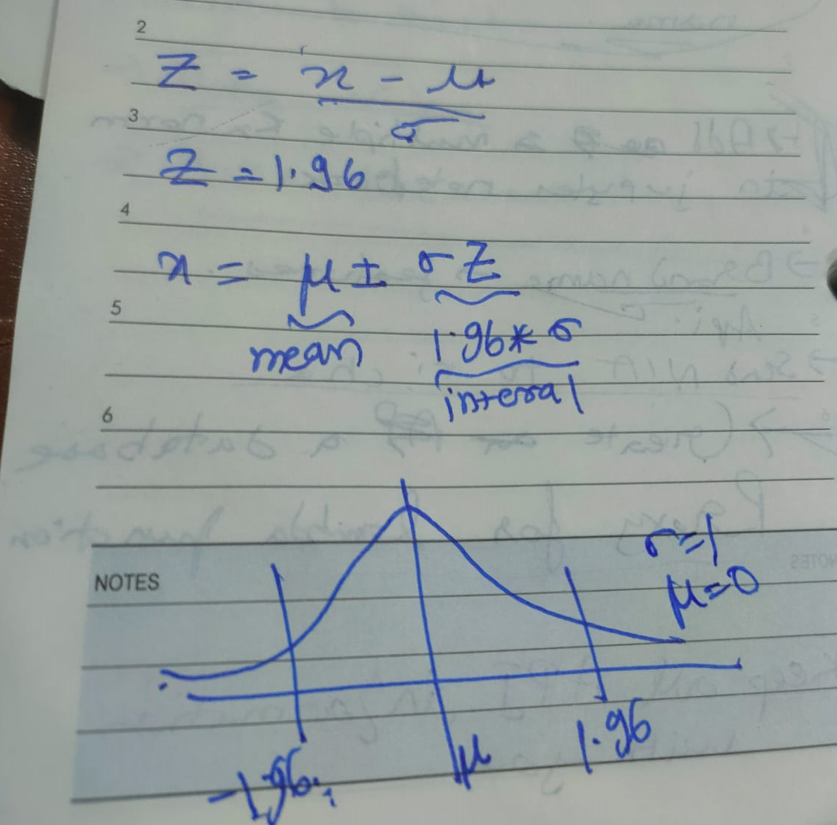

In [170]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

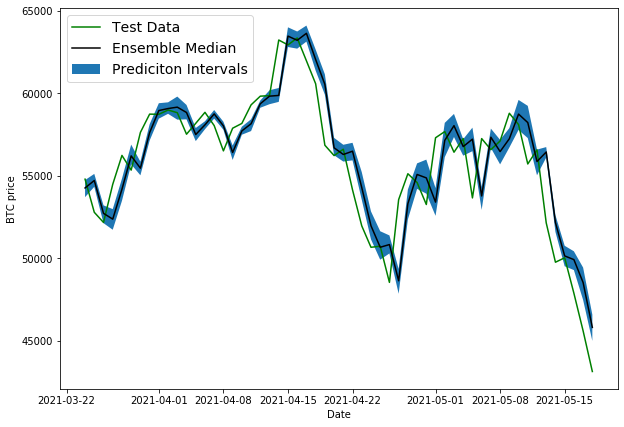

In [171]:
# Get the median/mean values of our ensemble preds
# We take the median here instead of the mean
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g-', label='Test Data')
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label='Ensemble Median')
plt.xlabel('Date')
plt.ylabel('BTC price')
# To plot upper and lower bounds, let's use full_between
plt.fill_between(X_test.index[offset:],lower[offset:], upper[offset:], label='Prediciton Intervals')
plt.legend(loc="upper left", fontsize=14);

Hmm...

So far all of our models predicitons have been lagging behind the test data...
As is they're replicationg what the naive model does and jsut predict the previous timestep as the next timestep

> **Note**: These prediciton intervals are estimates themselved. And they have been created with the assumption that our model's data is from a normal distribution.



## Aside: two types of uncertainty (coconut and subway)


Uncertainty estimates in machines leaning seek out to qualitatively and quantitatively answer the following questions:
1. What can my model know? (with perfect data, what's possible for a model to learn)
2. What doesn't my model know? (what can a model never predict? Or would it be helpful if a model tells you that when it's making a prediciton it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about: 

* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.
  * Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at *exactly* 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
  * When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).

* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.
  * The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach. 
    * If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing? 
    * But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
  * Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.

> 📖 **Resources:** Places to learn more about uncertainty in machine learning/forecasting:
* 🎥 [MIT 6.S191: Evidential Deep Learning and Uncertainty](https://youtu.be/toTcf7tZK8c) 
* [Uncertainty quantification on Wikipedia](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty)
* [*Why you should care about the Nate Silver vs. Nassim Taleb Twitter war*](https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc) by Isaac Faber - a great insight into the role of uncertainty in the example of election prediction. 
* [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) by Skander Hannachi - fantastic outline of some of the main mistakes people make when building forecasting models, especially forgetting about uncertainty estimates.
* [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) - a discussion on techniques Uber used to engineer uncertainty estimates into their time sereis neural networks.

## Model 9: Train a model on the full historical data to make predictions into future

So far all of our models have predicted on the test dataset, however, this is only a pseudo-future.

Let's now build a model which is capable of predicitng into the future!

In [172]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [173]:
HORIZON = 1
WINDOW_SIZE = 7

In [174]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [175]:
# Train model on entire data to make predicition for the next day
X_all = bitcoin_prices_windowed.dropna().drop(['Price', 'block_reward'], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

X_all.shape, y.shape

((2780, 7), (2780,))

In [176]:
X_all[:10], y_all[:10]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866],
        [125.9275 , 125.27966, 125.96116, 124.049  , 123.033  , 121.795  ,
         120.65533],
        [126.38333, 125.9275 , 125.27966, 125.96116, 124.049  , 123.033  ,
         121.795  ],
        [135.24199, 126.38333, 125.9275 , 125.27966, 125.96116, 124.049  ,
         123.033  ],
        [133.20333, 135.24199, 126.38333, 125.9275 , 125.27966, 125.96116,
         124.049  ],
        [142.76333, 133.20333, 135.24199, 126.38333, 125.9275 , 125.27966,
         125.96116]]),
 array([123.033  , 124.049  , 125.9611

Windows and labels ready! Let's turn them into performance optimized TensorFlow Datasets by:
1. Turning `X_all` and `y_all` into tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
2. Combining the features and labels into a Dataset tuple using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the data using [`tf.data.Dataset.batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`tf.data.Dataset.prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) respectively

In [177]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024  # taken from Appendix D in N-BEATS paper
dataset_all =  dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [178]:
tf.random.set_seed(42)

# Create a model

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future predicitions
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions on the future

In [179]:
# How many timesteps to predict into the future
INTO_FUTURE = 14

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)

To do so, we'll build the following steps:

1. Function which takes as input: 
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on

2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction.

In [180]:
y_all[-WINDOW_SIZE:]

array([56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361, 43144.47129086])

In [181]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future=INTO_FUTURE, window_size=WINDOW_SIZE) -> list:
    """
    Make future forecasts into_future steps after values ends.

    Returns future forecasts as list of floats.
    """

    # 2. Create an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]

    # 3. Make into_future number of predicitons, altering the data which gets predicted on eac
    for _ in range(into_future):
        # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts
        future_pred = model.predict(tf.expand_dims(last_window, axis=0)) # Add extra dimension for batch size
        print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
        
        # Append predictions to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast

In [182]:
X_all.shape, y_all.shape

((2780, 7), (2780,))

In [183]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55881.53125

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55881.53125   ] -> Prediction: 51063.06640625

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55881.53125    51063.06640625] -> Prediction: 48624.890625

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55881.53125    51063.06640625 48624.890625  ] -> Prediction: 48238.2890625

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55881.53125
 51063.06640625 48624.890625   48238.2890625 ] -> Prediction: 48016.4140625

Predicting on: 
 [45604.61575361 43144.47129086 55881.53125    51063.06640625
 48624.890625   48238.2890625  48016.4140625 ] -> Prediction: 47004.7421875

Predicting on: 
 [43144.47129086 55881.53125    51063.06640625 48624.890625

In [184]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


### Plot future forecasts

In [185]:
future_forecast

[55881.53,
 51063.066,
 48624.89,
 48238.29,
 48016.414,
 47004.742,
 48464.332,
 54163.51,
 49864.2,
 47810.64,
 48372.215,
 49084.742,
 48913.08,
 50547.56]

In [186]:
def get_future_date(start_date, into_future, offset=1):
    """
    Returns array of datetime values from ranging from start_date to start_date + into_future.

    start_date: date to start range (np.datetime64)
    into_future: number of days to add onto start date for range (int)
    offset: number of days to offset start_date by (default 1)
    """

    start_date = start_date + np.timedelta64(offset, 'D') #specify start date, 'D' stands for date
    end_date = start_date + np.timedelta64(into_future, 'D')

    return np.arange(start_date, end_date, dtype='datetime64[D]') # return a date range between start date and end date

In [188]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [189]:
# Get next two weeks of timesteps
next_time_steps = get_future_date(start_date=last_timestep, into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [190]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55881.53 , 51063.066, 48624.89 , 48238.29 , 48016.414,
        47004.742, 48464.332, 54163.51 , 49864.2  , 47810.64 , 48372.215,
        49084.742, 48913.08 , 50547.56 ], dtype=float32))

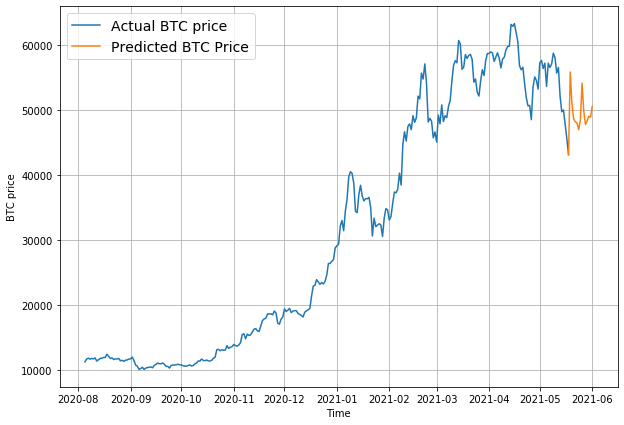

In [191]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format='-', label='Actual BTC price')
plot_time_series(next_time_steps, future_forecast, format='-', label='Predicted BTC Price')

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [192]:
# Let's introduce a turkey problem in our BTC data (price of BTC fall 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] /100

In [193]:
# Manufacture an extra price on the end ( to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [194]:
btc_price[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 43144.4712908603]

Notice the last value is 100x lower than what it actually was (remember, this is not a real data point, its only to illustrate the effects of the turkey problem).

Now we've got Bitcoin prices including a turkey problem data point, let's get the timesteps. 

In [195]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

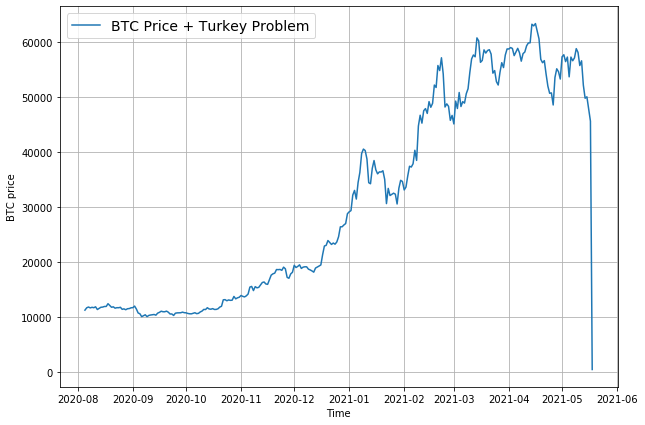

In [196]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format='-',
                 label='BTC Price + Turkey Problem',
                 start=2500)

In [197]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)

In [198]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [199]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = 'model_10_turkey_model'
turkey_model.compile(loss='mae',
                        optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train,
                 y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


In [200]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 701.3091


701.30908203125

In [201]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model('model_experiments/model_10_turkey_model/')
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 639.4271


639.4270629882812

In [202]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8855.644, 8789.629, 9038.994, 8794.518, 8762.857, 8737.981,
       8679.887, 8547.627, 8457.898, 8536.623], dtype=float32)>

In [203]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                 y_pred=turkey_preds)
turkey_results

{'mae': 17136.684,
 'mse': 614939460.0,
 'rmse': 23728.252,
 'mape': 121.466064,
 'mase': 26.519075}

And with just one value change, our error metrics go through the roof.

To make sure, let's remind ourselves of how model_1 went on unmodified Bitcoin data (no turkey problem).

In [204]:
model_1_results

{'mae': 568.54987,
 'mse': 1172588.0,
 'rmse': 1082.8611,
 'mape': 2.5492294,
 'mase': 0.99878466}

By changing just one value, the `turkey_model` MAE increases almost 30x over `model_1`.

Finally, we'll visualize the turkey predictions over the test turkey data.

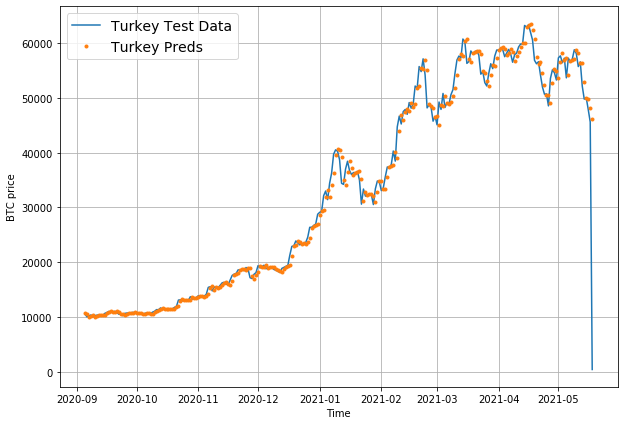

In [205]:
plt.figure(figsize=(10,7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format='-',
                 label='Turkey Test Data',
                 start=offset)

plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label='Turkey Preds',
                 start=offset);


## Comapre models

In [206]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.549866,1.172588e+06,1082.861084,2.549229,0.998785
model_2_dense_w30_h1,608.848022,1.284314e+06,1133.276001,2.768066,1.064272
model_3_dense_w30_h7,1228.523682,5.328784e+06,1413.747192,5.477446,2.186089
model_4_CONV1D,569.032715,1.169842e+06,1081.592163,2.551526,0.999633
model_5_LSTM,568.980652,1.177185e+06,1084.981689,2.535250,0.999541
model_6_multivariate,568.449219,1.166159e+06,1079.888428,2.549767,0.998608
model_8_NBEATs,588.349731,1.220197e+06,1104.625366,2.750486,1.033568
model_9_ensemble,564.690186,1.139178e+06,1067.322754,2.574836,0.992004
model_10_turkey,17136.683594,6.149395e+08,23728.251953,121.466064,26.519075


In [207]:
model_results['mae'] # returns a pandas series

naive_model               567.980225
model_1_dense_w7_h1       568.549866
model_2_dense_w30_h1      608.848022
model_3_dense_w30_h7     1228.523682
model_4_CONV1D            569.032715
model_5_LSTM              568.980652
model_6_multivariate      568.449219
model_8_NBEATs            588.349731
model_9_ensemble          564.690186
model_10_turkey         17136.683594
Name: mae, dtype: float64

In [208]:
model_results[['mae']] # returns a pandas dataframe

,mae
naive_model,567.980225
model_1_dense_w7_h1,568.549866
model_2_dense_w30_h1,608.848022
model_3_dense_w30_h7,1228.523682
model_4_CONV1D,569.032715
model_5_LSTM,568.980652
model_6_multivariate,568.449219
model_8_NBEATs,588.349731
model_9_ensemble,564.690186
model_10_turkey,17136.683594


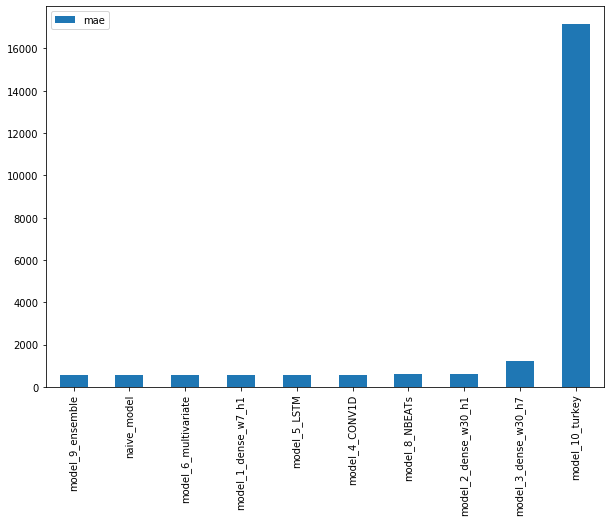

In [209]:
# Sort model results by MAE and plot them
model_results[['mae']].sort_values(by='mae').plot(figsize=(10,7), kind='bar')